# End-to-end DSPy Workflows Guide 

# TODO: Motivation - have this problem and going to solve it with dspy and that is why we believe ti is the right solution

This guide will cover the following topics:

## Creating a Multi-stage LLM Pipeline
- Building a pipeline with an untuned model in DSPy
- Implementing batch inference (using Ray data)

## Improving the Pipeline
1. Prompt optimization
2. Fine-tuning
    - How to make an 8B model perform almost as well as a 70B model in your pipeline
3. Combining fine-tuning with prompt optimization

## Deployment
- Steps to deploy the optimized pipeline and fine-tuned model to production

## Future Work and Open Questions
- Efficient batch inference with a DSPy pipeline
- Exploring different fine-tuning methods and hyperparameter sweeps

This guide aims to provide a comprehensive overview of building, optimizing, and deploying LLM pipelines using DSPy and Anyscale.

## Set up

Node Set up:

We will be running everything on a head node that uses 4xA100-80GB GPUs. I find that L4s are usually available and suitable for this usecase. You can also use any more powerful node.

To change to use A100 GPUs, click the "1 active node" in the top right corner, then for workspace node, click the pencil icon and navigate to the A100 tab and select the 4xA100 option. If you do not see A100 in the list of GPUs, they may not be available on your cloud. Choose another kind of GPU (This notebook has been tested on X, and Y as alternatives) (TODO)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# TODO(work): DSPy installation cell

# TODO: look at my own init file to see all the stupid extra pip installs

# !pip install -e dspy

# ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import dspy
import dsp
import os
import ujson

from dotenv import load_dotenv
# TODO: include cache in notebook
cache_dir = "/home/ray/default/dspy/cache"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
# I have included a .env.example with the necessary environment variables to be set
# You can also set them manually if you prefer

os.environ["DSP_CACHEDIR"] = cache_dir

load_dotenv()

dspy.settings.configure(experimental=True)

In [4]:
import litellm

litellm.set_verbose=False
litellm.suppress_debug_info=True

In [5]:
necessary_env_vars = [
    "DSP_CACHEDIR",
    "HF_TOKEN",
    "HF_HOME"
]

for var in necessary_env_vars:
    assert os.environ[var], f"{var} is not set"

In [6]:
import ray

if not ray.is_initialized():
    ray.init(runtime_env={"env_vars": os.environ, "py_modules": [dspy, dsp]})

2024-10-11 04:42:23,070	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.15.200:6379...
2024-10-11 04:42:23,079	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-11 04:42:23,104	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy/dspy'.
2024-10-11 04:42:23,136	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_6b744d49fc79efc9.zip' (0.89MiB) to Ray cluster...
2024-10-11 04:42:23,146	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_6b744d49fc79efc9.zip'.
2024-10-11 04:42:23,158	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/default/dspy/dsp'.
2024-10-11 04:42:23,179	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_4286993d40f18b4f.zip' (0.59MiB) to Ray cluster...
2024-10-11 04:42:23,182	INFO packaging.py:372 -- Successfully pushed file package 'g

We will make use of a random number generator in this notebook. We are creating a Random object here to ensure that our notebook is reproducible.

In [7]:
import random

rng = random.Random(0)

# Creating your multi-stage LLM pipeline

In [8]:
from dspy.datasets import HotPotQA
from dspy.evaluate import Evaluate
from dsp.utils.utils import deduplicate


# We are setting the experimental flag to True to make use of the fine-tuning
# features that are still in development.
dspy.settings.configure(experimental=True)

class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

class IntentClassificationModule(dspy.Module):
    def __init__(self):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(["activate_my_card", "cancel_transfer", "cash_withdrawal_charge", "declined_card_payment", "declined_cash_withdrawal", "direct_debit_payment_not_recognised", "extra_charge_on_statement", "pending_card_payment", "pending_top_up", "Refund_not_showing_up", "request_refund", "reverted_card_payment", "transaction_charged_twice", "transfer_fee_charged", "transfer_not_received_by_recipient", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"])

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        # if sanitized_prediction.label not in self.valid_labels:
        #     for label in self.valid_labels:
        #         if label in sanitized_prediction.label:
        #             sanitized_prediction.label = label
        #             break
        #     # this means that the prediction was not in the valid labels
        #     # Could do edit distance or something more sophisticated here
        #     # but for now just take the first
        #     sanitized_prediction.label = self.valid_labels[0]
        return sanitized_prediction



# Let's break down the Text to SQL program

Below we load the dataset using a built in `HotPotQA` dataset class from DSPy.

We set the `train_seed` and `eval_seed` to `0` for reproducibility and the `test_size` to `0` because we do not need a test set for this tutorial.

In [9]:
# Prepare the dataset
from dspy.datasets import DataLoader

dl = DataLoader()
full_trainset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="train"
)

full_testset = dl.from_huggingface(
    dataset_name="PolyAI/banking77", # Dataset name from Huggingface
    fields=("label", "text"), # Fields needed
    input_keys=("text",), # What our model expects to recieve to generate an output
    split="test"
)

# Find the 15 most common class labels
from collections import Counter

# Count occurrences of each label
label_counts = Counter(example['label'] for example in full_trainset)
print(label_counts)

# Get the 15 most common labels
top_25_labels = set([label for label, _ in label_counts.most_common(25)])

# Filter the datasets to only include examples with the top 15 labels
full_trainset_filtered = [example for example in full_trainset if example['label'] in top_25_labels]
full_testset_filtered = [example for example in full_testset if example['label'] in top_25_labels]

# Replace the original datasets with the filtered versions
full_trainset = full_trainset_filtered
full_testset = full_testset_filtered

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set: {len(full_trainset)}")
print(f"Test set: {len(full_testset)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")

Counter({15: 187, 28: 182, 6: 181, 75: 180, 19: 177, 63: 175, 26: 173, 64: 172, 66: 171, 5: 171, 52: 169, 16: 168, 17: 167, 34: 166, 76: 163, 51: 162, 53: 161, 20: 160, 45: 159, 0: 159, 8: 157, 7: 156, 11: 153, 25: 153, 47: 149, 48: 148, 61: 146, 59: 145, 46: 143, 13: 139, 35: 137, 73: 135, 27: 133, 54: 129, 39: 129, 9: 129, 24: 129, 67: 128, 4: 127, 36: 126, 71: 126, 2: 126, 21: 122, 30: 121, 74: 121, 29: 121, 42: 121, 31: 121, 43: 120, 33: 118, 49: 115, 58: 114, 57: 114, 70: 113, 65: 113, 32: 112, 12: 112, 14: 112, 56: 111, 1: 110, 55: 108, 38: 106, 44: 105, 69: 104, 62: 103, 68: 102, 40: 98, 60: 97, 37: 97, 50: 95, 3: 87, 22: 86, 41: 82, 18: 61, 10: 59, 72: 41, 23: 35})
Dataset filtered to top 25 labels. New sizes:
Training set: 4171
Test set: 1000
Top 25 labels: 0, 5, 6, 7, 8, 11, 15, 16, 17, 19, 20, 25, 26, 28, 34, 45, 47, 51, 52, 53, 63, 64, 66, 75, 76


In [10]:
int_to_label_dict = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "Refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal"
}

label_to_int_dict = {v: k for k, v in int_to_label_dict.items()}

In [11]:
labels_in_use = [int_to_label_dict[label] for label in top_25_labels]

print(labels_in_use)

def convert_int_to_label(example):
    example["label"] = int_to_label_dict[example["label"]]
    return example

full_trainset = [convert_int_to_label(example) for example in full_trainset]
full_testset = [convert_int_to_label(example) for example in full_testset]

print(full_trainset[0])

['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfer_fee_charged', 'transfer_not_received_by_recipient', 'wrong_amount_of_cash_received', 'wrong_exchange_rate_for_cash_withdrawal']
Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})


In [12]:
DEV_SIZE = 500
PROMPT_OPT_TRAIN_SIZE = 150
PROMPT_OPT_DEV_SIZE = 350

shuffled_trainset = [d for d in full_trainset]
rng.shuffle(shuffled_trainset)

devset = shuffled_trainset[:DEV_SIZE]
remaining_trainset = shuffled_trainset[DEV_SIZE:]

# The devset shouldn't overlap
ft_trainset = remaining_trainset
ft_optimizer_trainset = remaining_trainset[:PROMPT_OPT_TRAIN_SIZE]
ft_optimizer_devset = remaining_trainset[PROMPT_OPT_TRAIN_SIZE:PROMPT_OPT_TRAIN_SIZE+PROMPT_OPT_DEV_SIZE]

po_trainset = remaining_trainset[:-PROMPT_OPT_DEV_SIZE]
po_devset = remaining_trainset[-PROMPT_OPT_DEV_SIZE:]

testset = full_testset

Here we set up the metric and evaluator. We will be using the answer exact match metric.

The evaluator is what we will consider as our test set.

We choose `num_threads=90` because we are bottlenecked by the retrieval server, and through testing this is the maximum number of concurrent threads that can be run without causing issues for other people using the retrieval server.

In [13]:
# Prepare the metric and evaluator
from dspy.evaluate import answer_exact_match

NUM_THREADS = 50

def adjusted_exact_match(example, pred, trace=None, frac=1.0):
    example.answer = example.label
    pred.answer = pred.label
    return answer_exact_match(example, pred, trace, frac)

metric = adjusted_exact_match
common_kwargs = dict(metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

evaluate_devset = Evaluate(devset=devset, **common_kwargs)
evaluate_testset = Evaluate(devset=testset, **common_kwargs)

In [14]:
def read_jsonl(filename):
    with open(filename, "r") as f:
        return [ujson.loads(line) for line in f]

def write_jsonl(filename, data):
    with open(filename, "w") as f:
        for item in data:
            f.write(ujson.dumps(item) + "\n")

## Gathering baseline performance

run evaluate on a base pipeline

In [15]:
MAX_TOKENS = 1000
MODEL_PARAMETERS = {
  "max_tokens": MAX_TOKENS,
  "temperature": 0,
}

LOCAL_API_PARAMETERS = {
  "api_base": "http://localhost:8000/v1",
  "api_key": "fake-key-doesnt-matter"
}
vanilla_program = IntentClassificationModule()

In [16]:
# Note: Run above this to do all setup without launching any models

We will be using a local VLLM instance to run the initial benchmarks and data collection.

In [17]:
# Command for easy copying: 
# `vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`
# `vllm serve meta-llama/Llama-3.2-1B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`
# input("Press Enter once you have the vllm server running...")

# Gathering training data and running the 70B Model

Now that we have a baseline for the 8B model, let's run the 70B model and compare its performance.

## Preparation

Before running the 70B model:
1. Kill the 8B server (use `Ctrl+C`) to free up memory.
2. Remember to set your HF_TOKEN and HF_HOME environment variables
3. Use the following command to start the 70B server:

   ```
   vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2
   ```

## Parallelism Configuration

We've chosen pipeline parallelism and tensor parallelism of 2 for the 70B model based on our current setup. Here's the reasoning:

1. Model size: The 70B model has 30 parts of ~5 GB each (based on [HuggingFace documentation](https://huggingface.co/meta-llama/Meta-Llama-3.1-70B-Instruct/tree/main)).
   - Total size: 30 * 5 GB = 150 GB

2. Available VRAM:
   - Our GPUs: 80 GB VRAM x 4 = 320 GB
   - Tensor parallelism: floor(320/150) = 2
   - Pipeline parallelism: floor(num_gpus/2) = 2
   - To use all 4 GPUs efficiently:
     - Pipeline parallel size: 2
     - Tensor parallelism: 2

3. Alternative setup (8x24GB GPUs):
   - Pipeline parallel size: 1
   - Tensor parallelism: ceil(150/24) = 7

This configuration allows us to run the 70B model efficiently across our available GPU resources.

Note that I needed to add the HF_HOME var to my serve config

In [18]:
# Command for easy copying: 
# `export HF_HOME=/mnt/local_storage/huggingface`
# `vllm serve meta-llama/Meta-Llama-3.1-70B-Instruct --port 8000 --pipeline_parallel_size 2 --enable_prefix_caching --tensor_parallel_size 2`

# input("Press Enter once you have the vllm server running...")

In [19]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

In [20]:
# sanity check
with dspy.context(lm=llama_70b):
    test_predictor = IntentClassificationModule()
    sample_input = testset[15]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

Example({'label': 'card_arrival', 'text': 'I have been waiting longer than expected for my bank card, could you provide information on when it will arrive?'}) (input_keys={'text'})
card_arrival


In [21]:
# Lets see how the vanilla program performs on our small labeled dataset
# vanilla_program = IntentClassificationModule()
# with dspy.context(lm=llama_70b):
#     print("Evaluating the vanilla program on the devset using llama 70B...")
#     true_labeled_eval = evaluate_devset(vanilla_program)

# Optimizing the LLaMa 70B pipeline

Now we are ready to optimize the pipeline. We want to optimize the 70B pipeline in order to get the best possible data to then train our 8B model.

We will use Bootstrap Few Shot with Random Search (BFRS) to optimize the pipeline.

The essence of BFRS is to try out different configurations of few shot demonstrations per step and see which one works best on the validation set.

The cool part about BFRs is that it will automatically collect the "good" chains of thought for us and add them to the examples at each step.

Now we know how well the base pipeline performs, let's run prompt optimization on the pipeline in order to juice up the performance.

Let's go over what the hyperparameters mean:
- MAX_BOOTSTRAPPED_DEMOS: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- MAX_LABELED_DEMOS: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the gold answer.
- NUM_CANDIDATE_PROGRAMS: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with TODO (check)
- OPTIMIZER_NUM_TRAIN and OPTIMIZER_NUM_VAL: These are the number of examples that the optimizer will use for training and validation. Note that we will be taking the "validation" set from the trainset so as the actual validation set is untouched.

In [16]:
# Optimization hyperparameters
from dspy.teleprompt.random_search import BootstrapFewShotWithRandomSearch

# Define the hyperparameters for prompt optimization
MAX_BOOTSTRAPPED_DEMOS = 3
MAX_LABELED_DEMOS = 3
NUM_CANDIDATE_PROGRAMS = 6
OPTIMIZER_NUM_TRAIN = 100
OPTIMIZER_NUM_VAL = 300

In [17]:
# Initialize the optimizer
bfrs_optimizer = BootstrapFewShotWithRandomSearch(
    metric=metric,
    max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,
    max_labeled_demos=MAX_LABELED_DEMOS,
    num_candidate_programs=NUM_CANDIDATE_PROGRAMS,
    num_threads=NUM_THREADS,
    max_errors=10000
)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


In [24]:
# We have added this flag to save you some compute and time while running the notebook
COMPILE_PROGRAM = False
EVAL_PROGRAM = True

# Compile the optimizer and evaluate
with dspy.context(lm=llama_70b):
    vanilla_program = IntentClassificationModule()
    if COMPILE_PROGRAM:
        bfrs_base_program = bfrs_optimizer.compile(vanilla_program, trainset=po_trainset, valset=po_devset)
        bfrs_base_program.save(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    else:
        bfrs_base_program = IntentClassificationModule()
        bfrs_base_program.load(f"b25_70b_31_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}.json")
    if EVAL_PROGRAM:
        llama_70b_bfrs_eval = evaluate_devset(bfrs_base_program)


Average Metric: 414 / 500  (82.8): 100%|██████████| 500/500 [00:01<00:00, 415.06it/s]


In [25]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data, bootstrap_data_for_round
import ujson

# This should be moved inside the finetune_teleprompter class
def write_data(program, data, filename):
    print("Bootstrapping and writing data to", filename)
    correct_data = bootstrap_data(program, data, metric=metric, num_threads=NUM_THREADS, max_errors=10000)
    correct_data_round = [x for x in correct_data if x["score"]]

    # Convert the data to prompt completion format
    dataset = convert_to_module_level_message_data(correct_data_round, program=program, exclude_demos=True)
    
    dataset_formatted = [{"messages": x} for x in dataset]
    # Format the data for finetuning using the LM
    print("Writing dataset with length", len(dataset), "to", filename)
    write_jsonl(filename, dataset_formatted)

dataset_filenames = {f"ft_trainset_data_{len(ft_trainset)}.jsonl": ft_trainset, f"ft_valset_data_{len(devset)}.jsonl": devset}


WRITE_DATA = True
if WRITE_DATA:
    for filename, data in dataset_filenames.items():
        bootstrap_program = IntentClassificationModule()
        with dspy.context(lm=llama_70b):
            write_data(bootstrap_program, data, filename)

Bootstrapping and writing data to ft_trainset_data_3671.jsonl


Average Metric: 2853 / 3671  (77.7): 100%|██████████| 3671/3671 [00:12<00:00, 287.89it/s] 


Writing dataset with length 2853 to ft_trainset_data_3671.jsonl
Bootstrapping and writing data to ft_valset_data_500.jsonl


Average Metric: 397 / 500  (79.4): 100%|██████████| 500/500 [00:00<00:00, 610.20it/s]


Writing dataset with length 397 to ft_valset_data_500.jsonl


In [26]:
# Let's look at an example prompt completion pair!
# with open(f"trainset_data_banking_{TRAIN_SIZE}.json", "r") as f:
#     data_example = ujson.load(f)
from pprint import pprint
data_example = read_jsonl(f"ft_trainset_data_{len(ft_trainset)}.jsonl")[0]

print("Example prompt:")
pprint(data_example["messages"][:-1])
print("<end prompt>\n"+"-"*50)
print("Example completion:")
pprint(data_example["messages"][-1])
print("<end completion>\n"+"-"*50)

Example prompt:
[{'content': 'Your input fields are:\n'
             '1. `intent` (str): Intent of the query\n'
             '\n'
             'Your output fields are:\n'
             '1. `reasoning` (str)\n'
             '2. `label` (str): Type of the intent; Should just be one of the '
             '25 labels with no other text\n'
             '\n'
             'All interactions will be structured in the following way, with '
             'the appropriate values filled in.\n'
             '\n'
             '[[ ## intent ## ]]\n'
             '{intent}\n'
             '\n'
             '[[ ## reasoning ## ]]\n'
             '{reasoning}\n'
             '\n'
             '[[ ## label ## ]]\n'
             '{label}\n'
             '\n'
             '[[ ## completed ## ]]\n'
             '\n'
             'In adhering to this structure, your objective is: \n'
             '        As a part of a banking issue traiging system, classify '
             'the intent of a natural language quer

# Fine-tuning

We will use LLM Forge to fine-tune the 8B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format placed in a jsonl file).

We initially saved the data into a json file in prompt-completion format.

In order to prepare for finetuning, we need to do three steps:
1. Format the data into the correct format and verify that the data is valid
2. Upload the data to GCP
3. Generate the compute configuration file

After the compute configuration file is generated, we can submit the job to LLM Forge, using either the command line or using the anyscale jobs sdk.
TODO: Add the anyscale jobs sdk submit method

In [27]:
from dsp.modules.lm import TrainingMethod

train_path = f"ft_trainset_data_{len(ft_trainset)}.jsonl"
eval_path = f"ft_valset_data_{len(devset)}.jsonl"
method = TrainingMethod.SFT

kwargs = {
    "hyperparameters": {
        "num_devices": 4,
        "trainer_resources": None,
        "worker_resources": None,
        "generation_config": {
            "prompt_format": {
                "system": "<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "user": "<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>",
                "assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>",
                "trailing_assistant": "<|start_header_id|>assistant<|end_header_id|>\n\n", # inference-only
                "bos": "<|begin_of_text|>",
                "system_in_user": False,
                "default_system_message": ""
            },
        },
        "learning_rate": 3e-5,
        "num_epochs": 6,
        "train_batch_size_per_device": 32
    },
    "use_lora": True,
    # I think this needs to be set dynamically
    # "lora_dynamic_folder": "dspy/lora_weights/prodjob_qmulcjw4x8z599m8hkyja8tbmi/meta-llama/Llama-3.2-1B-Instruct"
}

SKIP_FT = False
if not SKIP_FT:
    # TODO: Get job working with LLMForge
    student_llama_1b = dspy.TrainableAnyscale(model="meta-llama/Llama-3.2-1B-Instruct")
    future = student_llama_1b.get_finetune(method, train_path, eval_path, **kwargs)
    model_names = future.result()

in multiopenai 0.0
Starting training process...
Reading and validating datasets...
No errors found in the dataset format using the OpenAI API.


The charge for finetuning is determined by the number of epochs multiplied by the number of billing tokens in the dataset. Here are the stats for this training dataset:
    num_billing_tokens: 1360475
    n_epochs: 3
    num_total_charge_tokens: 4081425
No errors found in the dataset format using the OpenAI API.
Converting data to JSONL format...
Submitting data to remote storage...
Number of items in train data: 2853
Uploading train data to S3 at gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_trainset_data_3671.jsonl


Copying file://ft_trainset_data_3671.jsonl to gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_trainset_data_3671.jsonl
  
.


Number of items in val data: 397
Uploading val data to S3 at gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_valset_data_500.jsonl


Copying file://ft_valset_data_500.jsonl to gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_valset_data_500.jsonl
  



Data submitted. Remote train path: gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_trainset_data_3671.jsonl, Remote eval path: gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_valset_data_500.jsonl
Generating configuration files...
Using default yaml template for model: configs/training/lora/llama-3-8b.yaml
{'model_id': 'meta-llama/Llama-3.2-1B-Instruct', 'train_path': 'gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_trainset_data_3671.jsonl', 'valid_path': 'gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/ft_valset_data_500.jsonl', 'context_length': 512, 'num_devices': 4, 'num_epochs': 6, 'train_batch_size_per_device': 32, 'eval_batch_size_per_device': 16,

(anyscale +37.3s) Uploading local dir '.' to cloud storage.
(anyscale +39.3s) Job 'dspy-llmforge-fine-tuning-job' submitted, ID: 'prodjob_trng9nlcejh28lxa9dsfn9rjrt'.
(anyscale +39.3s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_trng9nlcejh28lxa9dsfn9rjrt


Remote training started. Job ID: prodjob_trng9nlcejh28lxa9dsfn9rjrt
Waiting for training to complete...
Waiting for training to complete


(anyscale +39.5s) Waiting for job 'prodjob_trng9nlcejh28lxa9dsfn9rjrt' to reach target state SUCCEEDED, currently in state: STARTING
(anyscale +4m8.1s) Job 'prodjob_trng9nlcejh28lxa9dsfn9rjrt' transitioned from STARTING to RUNNING
(anyscale +14m14.2s) Job 'prodjob_trng9nlcejh28lxa9dsfn9rjrt' transitioned from RUNNING to SUCCEEDED
(anyscale +14m14.2s) Job 'prodjob_trng9nlcejh28lxa9dsfn9rjrt' reached target state, exiting


(autoscaler +1m46s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


Training completed.
Retrieving model information...
Model info retrieved: {'id': 'meta-llama/Llama-3.2-1B-Instruct:isaac:tdazn', 'base_model_id': 'meta-llama/Llama-3.2-1B-Instruct', 'cloud_id': 'cld_tffbxe9ia5phqr1unxhz4f7e1e', 'created_at': 1728621234, 'creator': 'isaac.miller+aviary@anyscale.com', 'ft_type': {}, 'generation_config': {'prompt_format': {'system': '<|start_header_id|>system<|end_header_id|>\n\n{instruction}<|eot_id|>', 'assistant': '<|start_header_id|>assistant<|end_header_id|>\n\n{instruction}<|eot_id|>', 'trailing_assistant': '<|start_header_id|>assistant<|end_header_id|>\n\n', 'user': '<|start_header_id|>user<|end_header_id|>\n{instruction}<|eot_id|>', 'bos': '<|begin_of_text|>', 'default_system_message': '', 'add_system_tags_even_if_message_is_empty': False, 'system_in_user': False, 'system_in_last_user': False, 'strip_whitespace': True}, 'stopping_sequences': None}, 'job_id': 'prodjob_trng9nlcejh28lxa9dsfn9rjrt', 'project_id': 'prj_dqb6ha67zubz3gdlvn2tmmglb8', 'sto

# Evaluation

Throughout this section, anything using 8B model (or technically 70B too) should use the new evaluate with ray data batch offline(or technically online) inference.

Probably worth testing offline with 8x8 threads vs just 64 threads to see if it makes a meaningful difference.

## Performance comparisons

- 70B
- 70B BSFS
- 8B
- 8B BSFT
- 8B BSFT + BSFS

The first model to run is the 8B model in order to collect a baseline of performance.

You can run the local VLLM instance with the following command:

Make sure to set your HF_TOKEN and HF_HOME environment variables

For Anyscale, putting models into /mnt/local_storage is a typical pattern.


`vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching`

Lets break down what this command does:
- `vllm serve` is the command to run the VLLM server
- `meta-llama/Meta-Llama-3.1-8B-Instruct` is the model to run
- `--port 8000` is the port to run the server on
- `--pipeline_parallel_size 4` is the number of pipeline parallel size to run the server with. We are using 4 because we have 4 GPUs all of which can hold an instance of the model.
- `--enable_prefix_caching` is the flag to enable the prefix caching. This will store and reuse the beginnings of prompts to avoid repeating the same computation. This is especially useful for DSPy since we are almost always using prompts with the same beginning parts in the form of few shot demonstrations.

In [28]:
# Now I need to eval the model with all the possible configurations
# 70B CoT: Have from above
# 1B CoT:
# 1B CoT + BSRS:        
# 1B CoT + BSFT(need to find best epoch):        
# 1B CoT + BSFT + BSRS: 

In [ ]:
print(model_names)

In [18]:
# TODO IMPORTANT IMPORTANT IMPORTANT
# model_names # I need to get this somehow. Waiting for response from Omar
import json
if False:
    with open("model_names.json", "w") as f:
        json.dump(model_names, f)
else:
    with open("model_names.json", "r") as f:
        model_names = json.load(f)


In [20]:
# Command for easy copying: 

llama_1b = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS)
finetuned_llamas_1b = {f: dspy.LM(model="openai/" + f, **LOCAL_API_PARAMETERS, **MODEL_PARAMETERS) for f in model_names}
all_llamas = {**finetuned_llamas_1b, "base": llama_1b}

### Moving things above this

We hope to bring the 8B performance up to at least 70B level

In [30]:
# from dspy.teleprompt import MIPROv2

# eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
# teleprompter = MIPROv2(prompt_model=llama_70b, task_model=llama_70b, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True)

# COMPILE_PROGRAM = True
# if COMPILE_PROGRAM:
#     with dspy.context(lm=llama_70b):
#         compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_batches=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, eval_kwargs=eval_kwargs, requires_permission_to_run=False)
#         compiled_program.save(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
# else:
#     compiled_program = TextToSQLModule()
#     compiled_program.load(f"t2sql_70b_31_MIPROv2_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")

# with dspy.context(lm=llama_70b):
#     llama_70b_mipro_eval = evaluate_devset(compiled_program)

### Bootstrap Data


In this section, we bootstrap data for fine-tuning. In the code block below, we are deciding which program should be used to collect the bootstraps. We are setting this to the prompt optimized program, but one could also set this to the vanilla program, though doing so would lead to lower quality bootstraps.

In [31]:
bootstrap_program = bfrs_base_program

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

First, we need to serve the base model and tell VLLM where to find the LoRA weights

Run the following command:

```
vllm serve meta-llama/Meta-Llama-3.1-8B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora
```

# Explanation:
This command starts a VLLM server to serve the Meta-Llama-3-8B-Instruct model with LoRA fine-tuning.
Here's a breakdown of the command:
- 'vllm serve': Starts the VLLM server
- 'meta-llama/Meta-Llama-3.1-8B-Instruct': Specifies the base model to use
- '--port 8000': Sets the server port to 8000
- '--pipeline_parallel_size 4': Enables pipeline parallelism with 4 stages
- '--enable_prefix_caching': Enables caching of prefixes for faster inference
- '--enable_lora': Enables LoRA (Low-Rank Adaptation) for fine-tuning
- '--lora_modules mhqa-lora=/mnt/local_storage/dspy/mhqa-lora': Specifies the name of the LoRA module and the path to the LoRA weights. We use the name instead of the base model name when trying to use the LoRA weights. If we just use the base model name, the server will ignore the LoRA weights.

This setup allows us to serve a fine-tuned version of the 8B model, which we'll use for subsequent evaluations.

In [33]:
# TODO: Remove this section - RayLLM solves it but its helpful for the VLLM case
# Lets dynamically generate a vllm command that will load all the models
# base = "vllm serve meta-llama/Llama-3.2-1B-Instruct --port 8000 --pipeline_parallel_size 4 --enable_prefix_caching --enable_lora --lora_modules"
# for folder, path in folder_lora_location.items():
#     base += f" vllm/{folder}={path}"
# print(base)

In [35]:
# # Sanity check that the finetuned models are working
llama1 = list(finetuned_llamas_1b.values())[1]
with dspy.context(lm=llama1):
    print(llama1.model)
    test_predictor = IntentClassificationModule()
    sample_input = ft_trainset[11]
    print(sample_input)
    print(test_predictor(**sample_input.inputs()).label)

openai/meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-138
Example({'label': 'card_arrival', 'text': 'How much longer until I get my new card?', 'answer': 'card_arrival'}) (input_keys={'text'})


card_payment


Now let's try optimizing the program with the finetuned model

In [22]:
COMPILE_PROGRAM = True

ft_results = {}
for folder, llama in all_llamas.items():
    ft_results[folder] = {}
    vanilla_program = IntentClassificationModule()
    with dspy.context(lm=llama):
        devset_result = evaluate_devset(vanilla_program)
        testset_result = evaluate_testset(vanilla_program)
        ft_results[folder]["vanilla"] = {"devset": devset_result, "testset": testset_result}

        if COMPILE_PROGRAM:
            bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=ft_optimizer_trainset, valset=ft_optimizer_devset)
            bfrs_finetuned_program.save(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder.split('/')[-1]}.json")
        else:
            bfrs_finetuned_program = IntentClassificationModule()
            bfrs_finetuned_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder}.json")
        
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_testset = evaluate_testset(bfrs_finetuned_program)
        ft_results[folder]["bfrs"] = {"devset": llama_8b_bfrs_finetuned_eval, "true_labels": None, "testset": llama_8b_bfrs_finetuned_eval_testset}
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}, None, {llama_8b_bfrs_finetuned_eval_testset}")


Average Metric: 98.0 / 350  (28.0): 100%|██████████| 350/350 [00:14<00:00, 24.93it/s]


New best score: 28.0 for seed -3
Scores so far: [28.0]
Best score so far: 28.0


Average Metric: 98.0 / 350  (28.0): 100%|██████████| 350/350 [00:00<00:00, 1234.97it/s]


Scores so far: [28.0, 28.0]
Best score so far: 28.0


  5%|▌         | 8/150 [00:03<00:55,  2.54it/s]


Bootstrapped 3 full traces after 9 examples in round 0.


Average Metric: 93.0 / 350  (26.6): 100%|██████████| 350/350 [00:09<00:00, 36.63it/s]


Scores so far: [28.0, 28.0, 26.57]
Best score so far: 28.0


  4%|▍         | 6/150 [00:02<00:59,  2.42it/s]


Bootstrapped 2 full traces after 7 examples in round 0.


Average Metric: 113.0 / 350  (32.3): 100%|██████████| 350/350 [00:09<00:00, 38.54it/s]


New best score: 32.29 for seed 0
Scores so far: [28.0, 28.0, 26.57, 32.29]
Best score so far: 32.29


  3%|▎         | 4/150 [00:01<00:54,  2.68it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 93.0 / 350  (26.6): 100%|██████████| 350/350 [00:09<00:00, 36.55it/s]


Scores so far: [28.0, 28.0, 26.57, 32.29, 26.57]
Best score so far: 32.29


  1%|▏         | 2/150 [00:00<00:27,  5.42it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 101.0 / 350  (28.9): 100%|██████████| 350/350 [00:13<00:00, 25.58it/s]


Scores so far: [28.0, 28.0, 26.57, 32.29, 26.57, 28.86]
Best score so far: 32.29


  1%|▏         | 2/150 [00:00<00:59,  2.50it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 92.0 / 350  (26.3): 100%|██████████| 350/350 [00:11<00:00, 30.28it/s]


Scores so far: [28.0, 28.0, 26.57, 32.29, 26.57, 28.86, 26.29]
Best score so far: 32.29


  1%|▏         | 2/150 [00:00<00:59,  2.51it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 89.0 / 350  (25.4): 100%|██████████| 350/350 [00:14<00:00, 24.89it/s]


Scores so far: [28.0, 28.0, 26.57, 32.29, 26.57, 28.86, 26.29, 25.43]
Best score so far: 32.29


  5%|▌         | 8/150 [00:02<00:49,  2.86it/s]


Bootstrapped 3 full traces after 9 examples in round 0.


Average Metric: 106.0 / 350  (30.3): 100%|██████████| 350/350 [00:10<00:00, 32.31it/s]


Scores so far: [28.0, 28.0, 26.57, 32.29, 26.57, 28.86, 26.29, 25.43, 30.29]
Best score so far: 32.29
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfe

Average Metric: 324.0 / 1000  (32.4): 100%|██████████| 1000/1000 [00:33<00:00, 29.62it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-69: 32.4, None, 32.4


Average Metric: 120 / 350  (34.3): 100%|██████████| 350/350 [00:19<00:00, 17.83it/s]


New best score: 34.29 for seed -3
Scores so far: [34.29]
Best score so far: 34.29


Average Metric: 120 / 350  (34.3): 100%|██████████| 350/350 [00:00<00:00, 1194.04it/s]


Scores so far: [34.29, 34.29]
Best score so far: 34.29


 11%|█         | 16/150 [00:06<00:54,  2.48it/s]


Bootstrapped 3 full traces after 17 examples in round 0.


Average Metric: 144.0 / 350  (41.1): 100%|██████████| 350/350 [00:18<00:00, 18.57it/s]


New best score: 41.14 for seed -1
Scores so far: [34.29, 34.29, 41.14]
Best score so far: 41.14


  5%|▌         | 8/150 [00:02<00:49,  2.85it/s]


Bootstrapped 2 full traces after 9 examples in round 0.


Average Metric: 149.0 / 350  (42.6): 100%|██████████| 350/350 [00:18<00:00, 18.84it/s]


New best score: 42.57 for seed 0
Scores so far: [34.29, 34.29, 41.14, 42.57]
Best score so far: 42.57


  8%|▊         | 12/150 [00:03<00:45,  3.00it/s]


Bootstrapped 1 full traces after 13 examples in round 0.


Average Metric: 143.0 / 350  (40.9): 100%|██████████| 350/350 [00:20<00:00, 17.49it/s]


Scores so far: [34.29, 34.29, 41.14, 42.57, 40.86]
Best score so far: 42.57


  1%|▏         | 2/150 [00:00<00:26,  5.57it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 126.0 / 350  (36.0): 100%|██████████| 350/350 [00:17<00:00, 20.25it/s]


Scores so far: [34.29, 34.29, 41.14, 42.57, 40.86, 36.0]
Best score so far: 42.57


  2%|▏         | 3/150 [00:00<00:37,  3.93it/s]


Bootstrapped 1 full traces after 4 examples in round 0.


Average Metric: 114.0 / 350  (32.6): 100%|██████████| 350/350 [00:16<00:00, 20.88it/s]


Scores so far: [34.29, 34.29, 41.14, 42.57, 40.86, 36.0, 32.57]
Best score so far: 42.57


  3%|▎         | 4/150 [00:01<00:47,  3.04it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 115.0 / 350  (32.9): 100%|██████████| 350/350 [00:22<00:00, 15.63it/s]


Scores so far: [34.29, 34.29, 41.14, 42.57, 40.86, 36.0, 32.57, 32.86]
Best score so far: 42.57


  9%|▊         | 13/150 [00:03<00:41,  3.27it/s]


Bootstrapped 3 full traces after 14 examples in round 0.


Average Metric: 104.0 / 350  (29.7): 100%|██████████| 350/350 [00:18<00:00, 18.54it/s]


Scores so far: [34.29, 34.29, 41.14, 42.57, 40.86, 36.0, 32.57, 32.86, 29.71]
Best score so far: 42.57
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transf

Average Metric: 431.0 / 1000  (43.1): 100%|██████████| 1000/1000 [00:53<00:00, 18.65it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-138: 42.0, None, 43.1


Average Metric: 116 / 350  (33.1): 100%|██████████| 350/350 [00:18<00:00, 18.43it/s]


New best score: 33.14 for seed -3
Scores so far: [33.14]
Best score so far: 33.14


Average Metric: 116 / 350  (33.1): 100%|██████████| 350/350 [00:00<00:00, 1207.93it/s]


Scores so far: [33.14, 33.14]
Best score so far: 33.14


  9%|▊         | 13/150 [00:05<00:54,  2.49it/s]


Bootstrapped 3 full traces after 14 examples in round 0.


Average Metric: 148.0 / 350  (42.3): 100%|██████████| 350/350 [00:18<00:00, 18.96it/s]


New best score: 42.29 for seed -1
Scores so far: [33.14, 33.14, 42.29]
Best score so far: 42.29


  5%|▌         | 8/150 [00:03<00:56,  2.50it/s]


Bootstrapped 2 full traces after 9 examples in round 0.


Average Metric: 148.0 / 350  (42.3): 100%|██████████| 350/350 [00:18<00:00, 18.79it/s]


Scores so far: [33.14, 33.14, 42.29, 42.29]
Best score so far: 42.29


  7%|▋         | 10/150 [00:03<00:44,  3.14it/s]


Bootstrapped 1 full traces after 11 examples in round 0.


Average Metric: 122.0 / 350  (34.9): 100%|██████████| 350/350 [00:19<00:00, 18.02it/s]


Scores so far: [33.14, 33.14, 42.29, 42.29, 34.86]
Best score so far: 42.29


  1%|▏         | 2/150 [00:00<00:26,  5.54it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 122.0 / 350  (34.9): 100%|██████████| 350/350 [00:16<00:00, 20.63it/s]


Scores so far: [33.14, 33.14, 42.29, 42.29, 34.86, 34.86]
Best score so far: 42.29


  2%|▏         | 3/150 [00:00<00:36,  4.00it/s]


Bootstrapped 1 full traces after 4 examples in round 0.


Average Metric: 112.0 / 350  (32.0): 100%|██████████| 350/350 [00:16<00:00, 21.32it/s]


Scores so far: [33.14, 33.14, 42.29, 42.29, 34.86, 34.86, 32.0]
Best score so far: 42.29


  3%|▎         | 4/150 [00:01<00:58,  2.50it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 108.0 / 350  (30.9): 100%|██████████| 350/350 [00:19<00:00, 17.62it/s]


Scores so far: [33.14, 33.14, 42.29, 42.29, 34.86, 34.86, 32.0, 30.86]
Best score so far: 42.29


  9%|▊         | 13/150 [00:03<00:41,  3.29it/s]


Bootstrapped 3 full traces after 14 examples in round 0.


Average Metric: 122.0 / 350  (34.9): 100%|██████████| 350/350 [00:18<00:00, 18.58it/s]


Scores so far: [33.14, 33.14, 42.29, 42.29, 34.86, 34.86, 32.0, 30.86, 34.86]
Best score so far: 42.29
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transf

Average Metric: 386.0 / 1000  (38.6): 100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-115: 37.2, None, 38.6


Average Metric: 121 / 350  (34.6): 100%|██████████| 350/350 [00:18<00:00, 18.45it/s]


New best score: 34.57 for seed -3
Scores so far: [34.57]
Best score so far: 34.57


Average Metric: 121 / 350  (34.6): 100%|██████████| 350/350 [00:00<00:00, 1198.17it/s]


Scores so far: [34.57, 34.57]
Best score so far: 34.57


  5%|▌         | 8/150 [00:03<00:58,  2.43it/s]


Bootstrapped 3 full traces after 9 examples in round 0.


Average Metric: 125.0 / 350  (35.7): 100%|██████████| 350/350 [00:18<00:00, 18.95it/s]


New best score: 35.71 for seed -1
Scores so far: [34.57, 34.57, 35.71]
Best score so far: 35.71


  5%|▌         | 8/150 [00:03<00:56,  2.53it/s]


Bootstrapped 2 full traces after 9 examples in round 0.


Average Metric: 134.0 / 350  (38.3): 100%|██████████| 350/350 [00:16<00:00, 20.77it/s]


New best score: 38.29 for seed 0
Scores so far: [34.57, 34.57, 35.71, 38.29]
Best score so far: 38.29


  3%|▎         | 4/150 [00:01<00:53,  2.73it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 125.0 / 350  (35.7): 100%|██████████| 350/350 [00:17<00:00, 20.44it/s]


Scores so far: [34.57, 34.57, 35.71, 38.29, 35.71]
Best score so far: 38.29


  1%|▏         | 2/150 [00:00<00:25,  5.72it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 111.0 / 350  (31.7): 100%|██████████| 350/350 [00:16<00:00, 21.09it/s]


Scores so far: [34.57, 34.57, 35.71, 38.29, 35.71, 31.71]
Best score so far: 38.29


  2%|▏         | 3/150 [00:01<01:00,  2.41it/s]


Bootstrapped 1 full traces after 4 examples in round 0.


Average Metric: 110.0 / 350  (31.4): 100%|██████████| 350/350 [00:18<00:00, 19.34it/s]


Scores so far: [34.57, 34.57, 35.71, 38.29, 35.71, 31.71, 31.43]
Best score so far: 38.29


  3%|▎         | 4/150 [00:01<01:03,  2.31it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 101.0 / 350  (28.9): 100%|██████████| 350/350 [00:22<00:00, 15.81it/s]


Scores so far: [34.57, 34.57, 35.71, 38.29, 35.71, 31.71, 31.43, 28.86]
Best score so far: 38.29


  7%|▋         | 11/150 [00:03<00:50,  2.75it/s]


Bootstrapped 3 full traces after 12 examples in round 0.


Average Metric: 126.0 / 350  (36.0): 100%|██████████| 350/350 [00:17<00:00, 19.51it/s]


Scores so far: [34.57, 34.57, 35.71, 38.29, 35.71, 31.71, 31.43, 28.86, 36.0]
Best score so far: 38.29
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transf

Average Metric: 375.0 / 1000  (37.5): 100%|██████████| 1000/1000 [00:50<00:00, 19.85it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-92: 38.4, None, 37.5


Average Metric: 56.0 / 350  (16.0): 100%|██████████| 350/350 [00:30<00:00, 11.51it/s]


New best score: 16.0 for seed -3
Scores so far: [16.0]
Best score so far: 16.0


2024-10-11T05:07:59.240084Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 56.0 / 350  (16.0): 100%|██████████| 350/350 [00:00<00:00, 1075.45it/s]


Scores so far: [16.0, 16.0]
Best score so far: 16.0


  9%|▊         | 13/150 [00:05<01:01,  2.23it/s]


Bootstrapped 3 full traces after 14 examples in round 0.


Average Metric: 62.0 / 350  (17.7): 100%|██████████| 350/350 [00:18<00:00, 19.41it/s]


New best score: 17.71 for seed -1
Scores so far: [16.0, 16.0, 17.71]
Best score so far: 17.71


  7%|▋         | 10/150 [00:04<00:58,  2.39it/s]


Bootstrapped 2 full traces after 11 examples in round 0.


Average Metric: 61.0 / 350  (17.4): 100%|██████████| 350/350 [00:22<00:00, 15.87it/s]


Scores so far: [16.0, 16.0, 17.71, 17.43]
Best score so far: 17.71


  3%|▎         | 4/150 [00:01<00:55,  2.64it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 65.0 / 350  (18.6): 100%|██████████| 350/350 [00:23<00:00, 15.11it/s]


New best score: 18.57 for seed 1
Scores so far: [16.0, 16.0, 17.71, 17.43, 18.57]
Best score so far: 18.57


  3%|▎         | 5/150 [00:01<00:52,  2.79it/s]


Bootstrapped 1 full traces after 6 examples in round 0.


Average Metric: 100.0 / 350  (28.6): 100%|██████████| 350/350 [00:22<00:00, 15.66it/s]


New best score: 28.57 for seed 2
Scores so far: [16.0, 16.0, 17.71, 17.43, 18.57, 28.57]
Best score so far: 28.57


  1%|▏         | 2/150 [00:00<01:09,  2.12it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 79.0 / 350  (22.6): 100%|██████████| 350/350 [00:27<00:00, 12.68it/s]


Scores so far: [16.0, 16.0, 17.71, 17.43, 18.57, 28.57, 22.57]
Best score so far: 28.57


  3%|▎         | 4/150 [00:01<00:58,  2.48it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 54.0 / 350  (15.4): 100%|██████████| 350/350 [00:23<00:00, 14.65it/s]


Scores so far: [16.0, 16.0, 17.71, 17.43, 18.57, 28.57, 22.57, 15.43]
Best score so far: 28.57


 23%|██▎       | 35/150 [00:18<00:59,  1.94it/s]


Bootstrapped 3 full traces after 36 examples in round 0.


Average Metric: 96.0 / 350  (27.4): 100%|██████████| 350/350 [00:22<00:00, 15.72it/s]


Scores so far: [16.0, 16.0, 17.71, 17.43, 18.57, 28.57, 22.57, 15.43, 27.43]
Best score so far: 28.57
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transfe

Average Metric: 290.0 / 1000  (29.0): 100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-46: 27.6, None, 29.0


Average Metric: 68.0 / 350  (19.4): 100%|██████████| 350/350 [00:22<00:00, 15.87it/s]


New best score: 19.43 for seed -3
Scores so far: [19.43]
Best score so far: 19.43


2024-10-11T05:14:26.154292Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 68.0 / 350  (19.4): 100%|██████████| 350/350 [00:01<00:00, 266.56it/s]


Scores so far: [19.43, 19.43]
Best score so far: 19.43


  5%|▌         | 8/150 [00:08<02:33,  1.08s/it]


Bootstrapped 3 full traces after 9 examples in round 0.


Average Metric: 84.0 / 350  (24.0): 100%|██████████| 350/350 [00:23<00:00, 15.18it/s]


New best score: 24.0 for seed -1
Scores so far: [19.43, 19.43, 24.0]
Best score so far: 24.0


  7%|▋         | 10/150 [00:03<00:45,  3.08it/s]


Bootstrapped 2 full traces after 11 examples in round 0.


Average Metric: 79.0 / 350  (22.6): 100%|██████████| 350/350 [00:14<00:00, 24.00it/s]


Scores so far: [19.43, 19.43, 24.0, 22.57]
Best score so far: 24.0


  3%|▎         | 4/150 [00:01<00:40,  3.65it/s]


Bootstrapped 1 full traces after 5 examples in round 0.


Average Metric: 106.0 / 350  (30.3): 100%|██████████| 350/350 [00:20<00:00, 17.13it/s]


New best score: 30.29 for seed 1
Scores so far: [19.43, 19.43, 24.0, 22.57, 30.29]
Best score so far: 30.29


  8%|▊         | 12/150 [00:04<00:53,  2.59it/s]


Bootstrapped 1 full traces after 13 examples in round 0.


Average Metric: 83.0 / 350  (23.7): 100%|██████████| 350/350 [00:18<00:00, 18.77it/s]


Scores so far: [19.43, 19.43, 24.0, 22.57, 30.29, 23.71]
Best score so far: 30.29


  1%|▏         | 2/150 [00:00<01:04,  2.29it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 80.0 / 350  (22.9): 100%|██████████| 350/350 [00:23<00:00, 14.86it/s]


Scores so far: [19.43, 19.43, 24.0, 22.57, 30.29, 23.71, 22.86]
Best score so far: 30.29


  2%|▏         | 3/150 [00:00<00:46,  3.14it/s]


Bootstrapped 1 full traces after 4 examples in round 0.


Average Metric: 85.0 / 350  (24.3): 100%|██████████| 350/350 [00:19<00:00, 18.18it/s]


Scores so far: [19.43, 19.43, 24.0, 22.57, 30.29, 23.71, 22.86, 24.29]
Best score so far: 30.29


 13%|█▎        | 20/150 [00:05<00:35,  3.71it/s]


Bootstrapped 3 full traces after 21 examples in round 0.


Average Metric: 72.0 / 350  (20.6): 100%|██████████| 350/350 [00:14<00:00, 23.37it/s]


Scores so far: [19.43, 19.43, 24.0, 22.57, 30.29, 23.71, 22.86, 24.29, 20.57]
Best score so far: 30.29
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'transaction_charged_twice', 'transf

Average Metric: 321.0 / 1000  (32.1): 100%|██████████| 1000/1000 [00:45<00:00, 21.95it/s]


result for meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-23: 29.0, None, 32.1


Average Metric: 3.0 / 350  (0.9): 100%|██████████| 350/350 [00:15<00:00, 23.11it/s]


New best score: 0.86 for seed -3
Scores so far: [0.86]
Best score so far: 0.86


2024-10-11T05:19:31.092623Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-11T05:19:31.094176Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
2024-10-11T05:19:31.095741Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys([]). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 3.0 / 350  (0.9): 100%|██████████| 350/350 [00:03<00:00, 106.76it/s]


Scores so far: [0.86, 0.86]
Best score so far: 0.86


 52%|█████▏    | 78/150 [00:16<00:15,  4.63it/s]


Bootstrapped 3 full traces after 79 examples in round 0.


Average Metric: 82.0 / 350  (23.4): 100%|██████████| 350/350 [00:11<00:00, 30.10it/s]


New best score: 23.43 for seed -1
Scores so far: [0.86, 0.86, 23.43]
Best score so far: 23.43


  0%|          | 0/150 [00:00<?, ?it/s]2024-10-11T05:20:03.333544Z [error    ] Failed to run or to evaluate example Example({'label': 'cash_withdrawal_charge', 'text': 'Why am I being charged for ATM fees?', 'answer': 'cash_withdrawal_charge'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:03.342668Z [error    ] Failed to run or to evaluate example Example({'label': 'reverted_card_payment', 'text': 'My card payment has been cancelled', 'answer': 'reverted_card_payment'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:03.351519Z [error    ] Failed to run or to evaluate example Example({'label': 'extra_charge_on_statement', 'text': 'Why have I been char

Bootstrapped 2 full traces after 33 examples in round 0.


Average Metric: 91.0 / 350  (26.0): 100%|██████████| 350/350 [00:09<00:00, 36.42it/s]


New best score: 26.0 for seed 0
Scores so far: [0.86, 0.86, 23.43, 26.0]
Best score so far: 26.0


  0%|          | 0/150 [00:00<?, ?it/s]2024-10-11T05:20:16.593220Z [error    ] Failed to run or to evaluate example Example({'label': 'request_refund', 'text': 'I would like to cancel a purchase.', 'answer': 'request_refund'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:16.602724Z [error    ] Failed to run or to evaluate example Example({'label': 'card_payment_not_recognised', 'text': "I don't understand where this charge came from.", 'answer': 'card_payment_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:16.795795Z [error    ] Failed to run or to evaluate example Example({'label': 'Refund_not_showing_up', 'text': 'A refund is takin

Bootstrapped 1 full traces after 26 examples in round 0.


Average Metric: 67.0 / 350  (19.1): 100%|██████████| 350/350 [00:09<00:00, 38.14it/s]


Scores so far: [0.86, 0.86, 23.43, 26.0, 19.14]
Best score so far: 26.0


  1%|▏         | 2/150 [00:00<00:00, 213.87it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 104.0 / 350  (29.7): 100%|██████████| 350/350 [00:09<00:00, 37.55it/s]


New best score: 29.71 for seed 2
Scores so far: [0.86, 0.86, 23.43, 26.0, 19.14, 29.71]
Best score so far: 29.71


  0%|          | 0/150 [00:00<?, ?it/s]2024-10-11T05:20:38.127347Z [error    ] Failed to run or to evaluate example Example({'label': 'card_payment_wrong_exchange_rate', 'text': 'I bought an item and the exchange rate was wrong.', 'answer': 'card_payment_wrong_exchange_rate'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:38.303740Z [error    ] Failed to run or to evaluate example Example({'label': 'Refund_not_showing_up', 'text': "I keep checking to see if I've received a refund that I requested from a seller, but I'm not seeing the refund. I need you to help me get the refund.", 'answer': 'Refund_not_showing_up'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  3%|

Bootstrapped 1 full traces after 8 examples in round 0.


2024-10-11T05:20:38.851490Z [error    ] Error for example in dev set: 		 Expected ['reasoning', 'label'] but got dict_keys(['reasoning']). Set `provide_traceback=True` to see the stack trace. [dspy.evaluate.evaluate] filename=evaluate.py lineno=198
Average Metric: 104.0 / 350  (29.7): 100%|██████████| 350/350 [00:00<00:00, 808.94it/s]


Scores so far: [0.86, 0.86, 23.43, 26.0, 19.14, 29.71, 29.71]
Best score so far: 29.71


  0%|          | 0/150 [00:00<?, ?it/s]2024-10-11T05:20:39.469546Z [error    ] Failed to run or to evaluate example Example({'label': 'transfer_fee_charged', 'text': "I don't think I was supposed to be charged so much.", 'answer': 'transfer_fee_charged'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:39.636268Z [error    ] Failed to run or to evaluate example Example({'label': 'card_payment_wrong_exchange_rate', 'text': 'When I was traveling abroad, the exchange rate was applied wrong.', 'answer': 'card_payment_wrong_exchange_rate'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
  1%|▏         | 2/150 [00:00<00:13, 11.27it/s]2024-10-11T05:20:39.647848Z [error    ] Fa

Bootstrapped 1 full traces after 19 examples in round 0.


Average Metric: 87.0 / 350  (24.9): 100%|██████████| 350/350 [00:09<00:00, 36.10it/s]


Scores so far: [0.86, 0.86, 23.43, 26.0, 19.14, 29.71, 29.71, 24.86]
Best score so far: 29.71


  1%|          | 1/150 [00:00<00:29,  5.05it/s]2024-10-11T05:20:50.555491Z [error    ] Failed to run or to evaluate example Example({'label': 'transaction_charged_twice', 'text': 'Why was I double charged?', 'answer': 'transaction_charged_twice'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:50.567067Z [error    ] Failed to run or to evaluate example Example({'label': 'card_payment_not_recognised', 'text': "There's a payment with my card that I definitely didn't do myself, never seen that name before.", 'answer': 'card_payment_not_recognised'}) (input_keys={'text'}) with <function adjusted_exact_match at 0x7aab0be40280> due to Expected ['reasoning', 'label'] but got dict_keys([]). [dspy.teleprompt.bootstrap] filename=bootstrap.py lineno=211
2024-10-11T05:20:50.577970Z [error    ] Failed to run or to evaluate example 

Bootstrapped 3 full traces after 92 examples in round 0.


Average Metric: 106.0 / 350  (30.3): 100%|██████████| 350/350 [00:10<00:00, 32.62it/s]


New best score: 30.29 for seed 5
Scores so far: [0.86, 0.86, 23.43, 26.0, 19.14, 29.71, 29.71, 24.86, 30.29]
Best score so far: 30.29
9 candidate programs found.
[('intent_classifier', Predict(StringSignature(intent -> reasoning, label
    instructions="As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\nThe intent should exactly match one of the following:\n['activate_my_card', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_arrival', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'declined_card_payment', 'declined_cash_withdrawal', 'direct_debit_payment_not_recognised', 'extra_charge_on_statement', 'pending_card_payment', 'pending_top_up', 'Refund_not_showing_up', 'request_refund', 'reverted_card_payment', 'tran

Average Metric: 289.0 / 1000  (28.9): 100%|██████████| 1000/1000 [00:33<00:00, 30.20it/s]


result for base: 27.8, None, 28.9


In [24]:
if True:
    import json
    with open("ft_results.json", "w") as f:
        json.dump(ft_results, f)
else:
    ft_results = json.load(open("ft_results.json"))
ft_results


{'meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-69': {'vanilla': {'devset': 26.2,
   'testset': 28.4},
  'bfrs': {'devset': 32.4, 'true_labels': None, 'testset': 32.4}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-138': {'vanilla': {'devset': 28.8,
   'testset': 32.3},
  'bfrs': {'devset': 42.0, 'true_labels': None, 'testset': 43.1}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-115': {'vanilla': {'devset': 28.2,
   'testset': 32.5},
  'bfrs': {'devset': 37.2, 'true_labels': None, 'testset': 38.6}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-92': {'vanilla': {'devset': 30.2,
   'testset': 34.1},
  'bfrs': {'devset': 38.4, 'true_labels': None, 'testset': 37.5}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-46': {'vanilla': {'devset': 15.6,
   'testset': 14.6},
  'bfrs': {'devset': 27.6, 'true_labels': None, 'testset': 29.0}},
 'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-23':

In [ ]:
ENSEMBLE_PROGRAM = True

# optimizer_trainset, optimizer_valset = get_optimizer_train_val_set(shuffled_trainset, OPTIMIZER_NUM_TRAIN, OPTIMIZER_NUM_VAL)
for folder, llama in all_llamas.items():
    with dspy.context(lm=llama):
        vanilla_program = IntentClassificationModule()
        bfrs_finetuned_program = IntentClassificationModule()
        bfrs_finetuned_program.load(f"simpleintent_1b_32_ft_bfrs_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}_{NUM_CANDIDATE_PROGRAMS}_{folder}.json")
        llama_8b_bfrs_finetuned_eval = evaluate_devset(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_true_labels = evaluate_true_labels(bfrs_finetuned_program)
        llama_8b_bfrs_finetuned_eval_testset = evaluate_testset(bfrs_finetuned_program)
        ft_results[folder]["bfrs"] = {"devset": llama_8b_bfrs_finetuned_eval, "true_labels": llama_8b_bfrs_finetuned_eval_true_labels, "testset": llama_8b_bfrs_finetuned_eval_testset}
        print(f"result for {folder}: {llama_8b_bfrs_finetuned_eval}, {llama_8b_bfrs_finetuned_eval_true_labels}, {llama_8b_bfrs_finetuned_eval_testset}")

In [ ]:
ft_results

NameError: name 'ft_results' is not defined

In [ ]:
import json
if True:
    ft_results = json.load(open("ft_results.json"))
    print(ft_results)

{'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-30': {'vanilla': {'devset': 10.07, 'true_labels': 13.0, 'testset': 12.1}, 'bfrs': {'devset': 30.93, 'true_labels': 25.0, 'testset': 33.9}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-15': {'vanilla': {'devset': 21.2, 'true_labels': 21.0, 'testset': 21.5}, 'bfrs': {'devset': 35.4, 'true_labels': 36.0, 'testset': 32.3}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-75': {'vanilla': {'devset': 24.6, 'true_labels': 28.0, 'testset': 23.0}, 'bfrs': {'devset': 39.67, 'true_labels': 34.0, 'testset': 39.1}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-90': {'vanilla': {'devset': 24.27, 'true_labels': 28.0, 'testset': 22.3}, 'bfrs': {'devset': 38.67, 'true_labels': 36.0, 'testset': 38.1}}, 'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-60': {'vanilla': {'devset': 23.2, 'true_labels': 27.0, 'testset': 20.9}, 'bfrs': {'devset': 40.87, 'true_labels': 37.0, 'testse

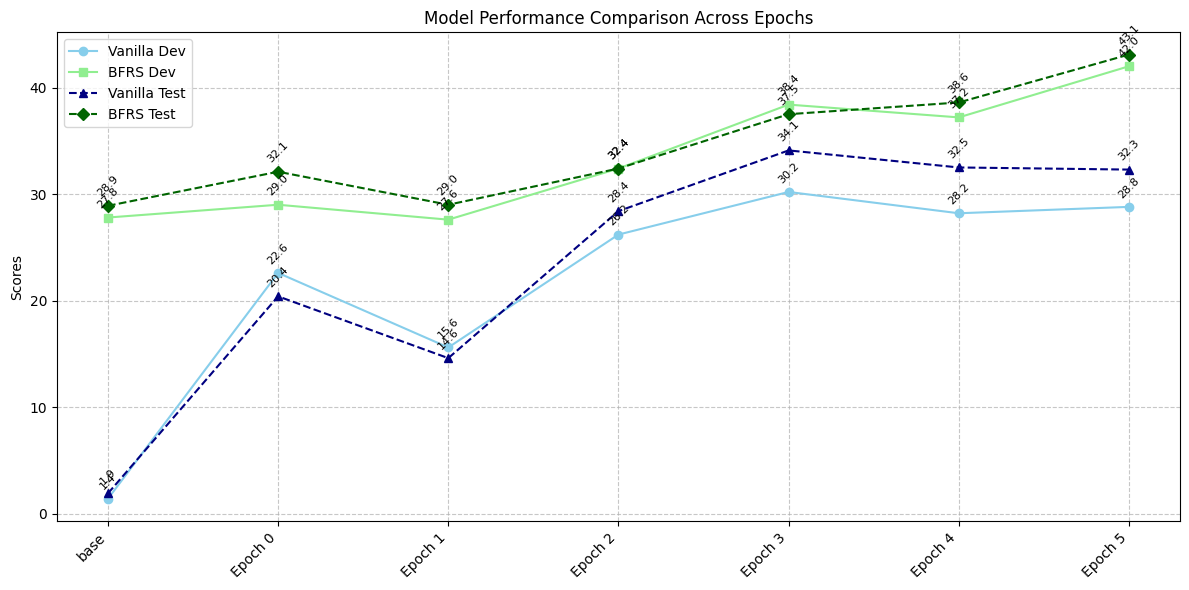

In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the ft_results data
# with open('ft_results.json', 'r') as f:
#     ft_results = json.load(f)
# {'meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-69': {'vanilla': {'devset': 26.2,
#    'testset': 28.4},
#   'bfrs': {'devset': 32.4, 'true_labels': None, 'testset': 32.4}},
#  'meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-138': {'vanilla': {'devset': 28.8,
#    'testset': 32.3},
#   'bfrs': {'devset': 42.0, 'true_labels': None, 'testset': 43.1}},
#  'meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-115': {'vanilla': {'devset': 28.2,
#    'testset': 32.5},
#   'bfrs': {'devset': 37.2, 'true_labels': None, 'testset': 38.6}},
#  'meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-92': {'vanilla': {'devset': 30.2,
#    'testset': 34.1},
#   'bfrs': {'devset': 38.4, 'true_labels': None, 'testset': 37.5}},
#  'meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-46': {'vanilla': {'devset': 15.6,
#    'testset': 14.6},
#   'bfrs': {'devset': 27.6, 'true_labels': None, 'testset': 29.0}},
#  'meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-23': {'vanilla': {'devset': 22.6,
#    'testset': 20.4},
#   'bfrs': {'devset': 29.0, 'true_labels': None, 'testset': 32.1}},
#  'base': {'vanilla': {'devset': 1.4, 'testset': 1.9},
#   'bfrs': {'devset': 27.8, 'true_labels': None, 'testset': 28.9}}}

# Prepare data for plotting
models = []
vanilla_devset = []
bfrs_devset = []
vanilla_testset = []
bfrs_testset = []

for model, results in ft_results.items():
    if model == "base":
        models.append("base")
    else:
        epoch = model.split(':')[1].split('-')[1]
        models.append(int(epoch))  # Store epoch as integer for proper sorting
    vanilla_devset.append(results['vanilla']['devset'])
    bfrs_devset.append(results['bfrs']['devset'])
    vanilla_testset.append(results['vanilla']['testset'])
    bfrs_testset.append(results['bfrs']['testset'])

# Sort the data by epoch, keeping "base" at the beginning
sorted_data = sorted(zip(models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset),
                     key=lambda x: (x[0] != "base", x[0]))
models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset = zip(*sorted_data)

# Convert back to string labels for x-axis
models = ["base" if m == "base" else f"Epoch {m}" for m in models]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines
ax.plot(models, vanilla_devset, marker='o', label='Vanilla Dev', linestyle='-', color='skyblue')
ax.plot(models, bfrs_devset, marker='s', label='BFRS Dev', linestyle='-', color='lightgreen')
ax.plot(models, vanilla_testset, marker='^', label='Vanilla Test', linestyle='--', color='navy')
ax.plot(models, bfrs_testset, marker='D', label='BFRS Test', linestyle='--', color='darkgreen')

# Add value labels on top of each point
for i, v in enumerate(zip(vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset)):
    for j, val in enumerate(v):
        ax.annotate(f'{val:.1f}', (i, val), xytext=(0, 5), 
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=8, rotation=45)

# Customize the plot
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison Across Epochs')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [45]:
# Find the scores for epoch 5
# epoch_5_scores = None
# for model, results in ft_results.items():
#     if "epochs-5" in model:
#         epoch_5_scores = results
#         break

# if epoch_5_scores:
#     print("Scores for Epoch 5:")
#     print(f"Vanilla Dev: {epoch_5_scores['vanilla']['devset']:.1f}")
#     print(f"BFRS Dev: {epoch_5_scores['bfrs']['devset']:.1f}")
#     print(f"Vanilla Test: {epoch_5_scores['vanilla']['testset']:.1f}")
#     print(f"BFRS Test: {epoch_5_scores['bfrs']['testset']:.1f}")
# Vanilla Dev: 28.8
# BFRS Dev: 42.0
# Vanilla Test: 32.3
# BFRS Test: 43.1
# else:
#     print("No scores found for Epoch 5")

for model, results in ft_results.items():
    print(model, results['vanilla']['devset'], results['bfrs']['devset'], results['vanilla']['testset'], results['bfrs']['testset'])

meta-llama/Llama-3.2-1B-Instruct:epochs-2-total-trained-steps-69 26.2 32.4 28.4 32.4
meta-llama/Llama-3.2-1B-Instruct:epochs-5-total-trained-steps-138 28.8 42.0 32.3 43.1
meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-115 28.2 37.2 32.5 38.6
meta-llama/Llama-3.2-1B-Instruct:epochs-3-total-trained-steps-92 30.2 38.4 34.1 37.5
meta-llama/Llama-3.2-1B-Instruct:epochs-1-total-trained-steps-46 15.6 27.6 14.6 29.0
meta-llama/Llama-3.2-1B-Instruct:epochs-0-total-trained-steps-23 22.6 29.0 20.4 32.1
base 1.4 27.8 1.9 28.9


base vanilla_devset 1.4 bfrs_devset 27.8 vanilla_testset 1.9 bfrs_testset 28.9
Epoch 0 vanilla_devset 22.6 bfrs_devset 29.0 vanilla_testset 20.4 bfrs_testset 32.1
Epoch 1 vanilla_devset 15.6 bfrs_devset 27.6 vanilla_testset 14.6 bfrs_testset 29.0
Epoch 2 vanilla_devset 26.2 bfrs_devset 32.4 vanilla_testset 28.4 bfrs_testset 32.4
Epoch 3 vanilla_devset 30.2 bfrs_devset 38.4 vanilla_testset 34.1 bfrs_testset 37.5
Epoch 4 vanilla_devset 28.2 bfrs_devset 37.2 vanilla_testset 32.5 bfrs_testset 38.6
Epoch 5 vanilla_devset 28.8 bfrs_devset 42.0 vanilla_testset 32.3 bfrs_testset 43.1


42.0 Epoch 5 42.0
best_vanilla_testset 32.3 best_bfrs_testset 43.1
base_vanilla_testset 1.9 base_bfrs_testset 28.9


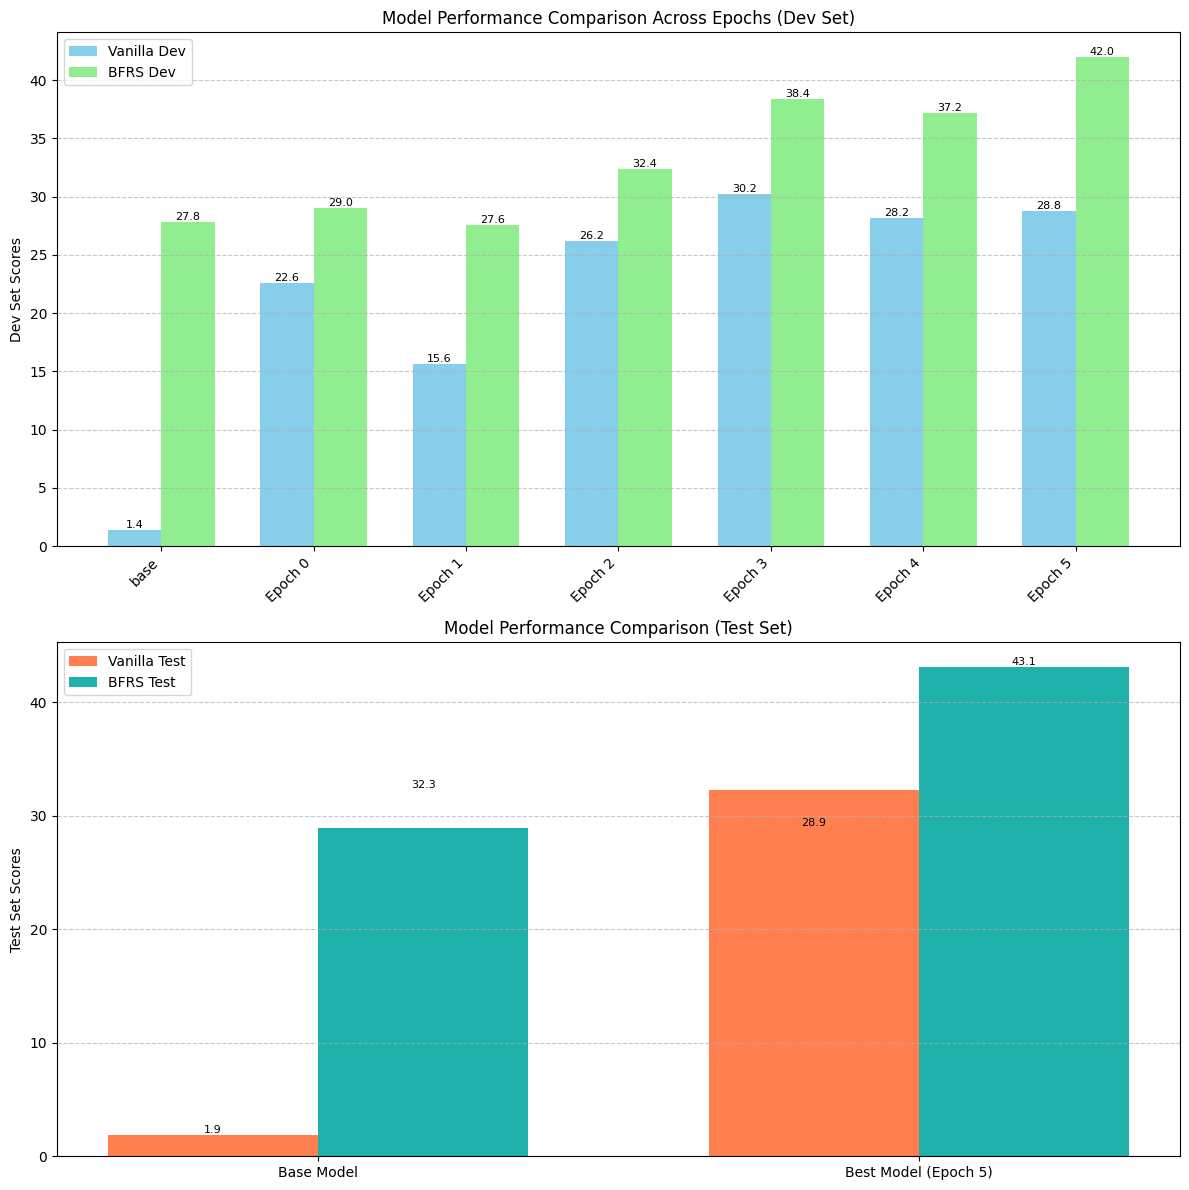

In [47]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
models = []
vanilla_devset = []
bfrs_devset = []
vanilla_testset = []
bfrs_testset = []

for model, results in ft_results.items():
    if model == "base":
        models.append("base")
    else:
        models.append("Epoch " + model.split(':')[1].split('-')[1])  # Extract epoch information
    vanilla_devset.append(results['vanilla']['devset'])
    bfrs_devset.append(results['bfrs']['devset'])
    vanilla_testset.append(results['vanilla']['testset'])
    bfrs_testset.append(results['bfrs']['testset'])

# Sort the data by epoch, keeping "base" at the beginning
sorted_data = sorted(zip(models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset),
                     key=lambda x: (x[0] != "base", x[0]))
models, vanilla_devset, bfrs_devset, vanilla_testset, bfrs_testset = zip(*sorted_data)

for i in range(len(models)):
    print(models[i], "vanilla_devset", vanilla_devset[i], "bfrs_devset", bfrs_devset[i], "vanilla_testset", vanilla_testset[i], "bfrs_testset", bfrs_testset[i])

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Adjust bar positions and width
x = np.arange(len(models))
width = 0.35

# Plot bars for Dev Set (top graph)
ax1.bar(x - width/2, vanilla_devset, width, label='Vanilla Dev', color='skyblue')
ax1.bar(x + width/2, bfrs_devset, width, label='BFRS Dev', color='lightgreen')

# Add value labels on top of each bar for Dev Set
for i, v in enumerate(vanilla_devset):
    ax1.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(bfrs_devset):
    ax1.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

# Customize the Dev Set plot
ax1.set_ylabel('Dev Set Scores')
ax1.set_title('Model Performance Comparison Across Epochs (Dev Set)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Find the highest devset score and its corresponding model
highest_devset_score = max(bfrs_devset)
highest_score_model = models[bfrs_devset.index(highest_devset_score)]

print(highest_devset_score, highest_score_model, bfrs_devset[models.index(highest_score_model)])

# Prepare data for the bottom graph
# Prepare data for the bottom graph (Test Set)
base_vanilla_testset = vanilla_testset[models.index("base")]
base_bfrs_testset = bfrs_testset[models.index("base")]

best_model_index = bfrs_devset.index(highest_devset_score)
best_vanilla_testset = vanilla_testset[best_model_index]
best_bfrs_testset = bfrs_testset[best_model_index]

print("best_vanilla_testset", best_vanilla_testset, "best_bfrs_testset", best_bfrs_testset)
print("base_vanilla_testset", base_vanilla_testset, "base_bfrs_testset", base_bfrs_testset)

# Plot bars for Test Set (bottom graph)
models_to_plot = ["Base Model", f"Best Model ({highest_score_model})"]
x_test = np.arange(len(models_to_plot))

ax2.bar(x_test - width/2, [base_vanilla_testset, best_vanilla_testset], width, label='Vanilla Test', color='coral')
ax2.bar(x_test + width/2, [base_bfrs_testset, best_bfrs_testset], width, label='BFRS Test', color='lightseagreen')

# Add value labels on top of each bar for Test Set
for i, v in enumerate([base_vanilla_testset, best_vanilla_testset]):
    ax2.text(i - width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate([base_bfrs_testset, best_bfrs_testset]):
    ax2.text(i + width/2, v, f'{v:.1f}', ha='center', va='bottom', fontsize=8)

# Customize the Test Set plot
ax2.set_ylabel('Test Set Scores')
ax2.set_title('Model Performance Comparison (Test Set)')
ax2.set_xticks(x_test)
ax2.set_xticklabels(models_to_plot)
ax2.legend()
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# from dspy.teleprompt import MIPROv2
# gpt4o = dspy.LM(model="gpt-4o", **MODEL_PARAMETERS)

# COMPILE_PROGRAM = True

# with dspy.context(lm=current_best):
#     vanilla_program = IntentClassificationModule()
#     if COMPILE_PROGRAM:
#         # eval_kwargs = dict(display_progress=True, display_table=0, num_threads=NUM_THREADS)
#         teleprompter = MIPROv2(prompt_model=gpt4o, task_model=current_best, metric=metric, num_candidates=10, init_temperature=0.9, verbose=True, num_threads=NUM_THREADS, max_errors=1000)
#         compiled_program = teleprompter.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset, num_trials=30, max_bootstrapped_demos=MAX_BOOTSTRAPPED_DEMOS,max_labeled_demos=MAX_LABELED_DEMOS, requires_permission_to_run=False)
#         compiled_program.save(f"simpleintent_1b_32_ft_mipro_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
#     else:
#         compiled_program = IntentClassificationModule()
#         compiled_program.load(f"simpleintent_1b_32_ft_mipro_{MAX_BOOTSTRAPPED_DEMOS}_{MAX_LABELED_DEMOS}.json")
#     llama_8b_ft_mipro_eval = evaluate_devset(compiled_program)

Lastly, lets give the base 8B model a fair chance by prompt optimizing it.

In [ ]:
# Now we can compare all iterations of this pipeline
print(f"Results for HotPotQA fine-tuning LLaMa 8B with a starting trainset")
print(f"    70B model (vanilla program): {llama_70b_base_eval}")
print(f"    70B model (bfrs program): {llama_70b_bfrs_eval}")
print(f"    8B model (vanilla program): {vanilla_8b_base_eval}")
print(f"    8B model (bfrs program): {llama_8b_bfrs_eval}")
print(f"    8B model (finetuned program): {llama_8b_finetuned_eval}")
print(f"    8B model (finetuned bfrs program): {llama_8b_bfrs_finetuned_eval}")
print(f"    8B model (finetuned mipro program): {llama_8b_ft_mipro_eval}")

TODO: Let's now use the new offline batch inference to evaluate the finetuned model with optimized program on the entire devset

In [ ]:
# TODO: implement once done

In [ ]:
raise NotImplementedError("Stop here")

# Serving

This is the second biggest unknown
I imagine it to be easy, but crazier things have happened

I need to keep a reference or link to the LLM forge job inside the LM.finetune method

how do I get the ray llm image!

We'll start by running the rayllm CLI command below to start the workflow to generate the service yaml configuration:
```bash
mkdir /home/ray/default/deploy/services
cd /home/ray/default/deploy/services
rayllm gen-config 
```

<img src="assets/cli.png" width=500 alt="todo! get this inage of what I need to serve">


## Batch offline inference
- Compare running inference using 
    - Ray Data 
    - multithreading on local VLLM thru HTTP
    - Multithreading to Ray Serve instance thru HTTP
- Dev time estimate: 7 days

<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services

# MARK: Synthetic 70B Labels

In [ ]:
# Lets do some data analysis and cleaning
# First we will convert the data to a pandas dataframe
import pandas as pd

# TODO: Move
# For realism of this scenario, we are going to delete all our labels except for our test set(which is cheating and we wouldn't have in production) and our 100 true labeled examples

def delete_labels(dataset):
    for example in dataset:
        if "label" in example:
            del example["label"]
    return dataset

trainset_to_label = delete_labels(trainset_to_label)
# Convert collected_data to a pandas DataFrame
data_dict = {
    'example': [item[0]["text"] for item in collected_data],
    'label': [item[1]["label"] for item in collected_data],
    'reasoning': [item[1]["reasoning"] for item in collected_data]
}
df = pd.DataFrame(data_dict)

# Save the DataFrame to a CSV file
df.to_csv("collected_data.csv", index=False)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("collected_data.csv")

# Display the DataFrame
print(df.head())

# Lets see how many labels are invalid (not in the top 25 most common labels)
df['label'].value_counts()
df_cleaned = df[df['label'].isin(labels_in_use)]
print("Length of cleaned dataframe:", len(df_cleaned))

# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv("collected_data_cleaned.csv", index=False)

dspy.settings.configure(experimental=True, lm=llama_70b)

from dspy.teleprompt.finetune_teleprompter import bootstrap_data,bootstrap_data_for_round, convert_to_module_level_message_data    

vanilla_program = IntentClassificationModule()
data = bootstrap_data(vanilla_program, trainset_to_label, metric=fake_metric, num_threads=NUM_THREADS, max_errors=10000)
data_example_ind_map = {data_dict["example_ind"]: idx for idx, data_dict in enumerate(data)}
# Convert the data to prompt completion format
dataset = convert_to_module_level_message_data(data, program=vanilla_program, exclude_demos=True)

training_data = data.copy()
for idx, data_dict in enumerate(training_data):
    fields_to_keep = ["example", "example_ind", "prediction"]
    training_data[idx] = {k: v for k, v in data_dict.items() if k in fields_to_keep}
    training_data[idx].update({"finetunable_data": dataset[idx]})

print(training_data[0])

filtered_training_data = [x for x in training_data if x["prediction"].label in labels_in_use]
TRAIN_SIZE_ADJUSTED = min(2000, len(filtered_training_data) - DEV_SIZE - PROMPT_OPT_TRAIN_SIZE - PROMPT_OPT_DEV_SIZE)
print(len(filtered_training_data), TRAIN_SIZE_ADJUSTED)

# save the training data for future use

if True:
    filtered_training_data = ujson.load(open("training_data.json", "r"))
    TRAIN_SIZE_ADJUSTED = min(2000, len(filtered_training_data) - DEV_SIZE - PROMPT_OPT_TRAIN_SIZE - PROMPT_OPT_DEV_SIZE)
else:
    with open("training_data.json", "w") as f:
        ujson.dump(filtered_training_data, f)

ft_trainset = filtered_training_data[:TRAIN_SIZE_ADJUSTED]
ft_devset = filtered_training_data[TRAIN_SIZE_ADJUSTED:TRAIN_SIZE_ADJUSTED+DEV_SIZE]
optimizer_trainset = filtered_training_data[TRAIN_SIZE_ADJUSTED+DEV_SIZE:TRAIN_SIZE_ADJUSTED+DEV_SIZE+PROMPT_OPT_TRAIN_SIZE]
optimizer_valset = filtered_training_data[TRAIN_SIZE_ADJUSTED+DEV_SIZE+PROMPT_OPT_TRAIN_SIZE:TRAIN_SIZE_ADJUSTED+DEV_SIZE+PROMPT_OPT_TRAIN_SIZE+PROMPT_OPT_DEV_SIZE]

def convert_example_predictions_to_example(dataset):
    data = []
    for item in dataset:
        data.append(dspy.Example(text=item["example"]["text"], label=item["prediction"]["label"], reasoning=item["prediction"]["reasoning"]).with_inputs("text"))
    return data

ft_devset_examples = convert_example_predictions_to_example(ft_devset)
optimizer_trainset = convert_example_predictions_to_example(optimizer_trainset)
optimizer_valset = convert_example_predictions_to_example(optimizer_valset)

evaluate_devset = Evaluate(devset=ft_devset_examples, metric=metric, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

# Note: Maybe dont use devset here
dataset_filenames = {f"trainset_data_banking_{TRAIN_SIZE}.jsonl": ft_trainset, f"trainset_val_data_banking_{DEV_SIZE}.jsonl": ft_devset}

for filename, data in dataset_filenames.items():
    # we first need to convert the data to be only the messages and to be in proper messages format
    messages_format = [{"messages": data_dict["finetunable_data"]} for data_dict in data]
    # print(messages_format[0])

    write_jsonl(filename, messages_format)

NameError: name 'trainset_to_label' is not defined

# MARK: Ensemble

In [ ]:
from dspy.teleprompt import Ensemble

# testing ensemble
top_programs = []

for folder, llama in all_llamas.items():
    with dspy.context(lm=llama):
        vanilla_program = IntentClassificationModule()
        bfrs_finetuned_program = bfrs_optimizer.compile(vanilla_program, trainset=optimizer_trainset, valset=optimizer_valset)
        devset_result = evaluate_devset(bfrs_finetuned_program)

        def wrapped_program(*args, **kwargs):
            with dspy.context(lm=llama):
                return bfrs_finetuned_program(*args, **kwargs)
        top_programs.append((wrapped_program, llama, devset_result))

top_3_devset = sorted(top_programs, key=lambda x: x[2], reverse=True)[:3]

teleprompter = Ensemble(reduce_fn=dspy.majority, size=None)
# print(top_3_devset)
programs = [p[0] for p in top_3_devset]
# print(programs)
compiled_program = teleprompter.compile(programs)
# # print(compiled_program)
eval_result = evaluate_devset(compiled_program)
eval_testset = evaluate_testset(compiled_program)
print(f"result for best_ensemble: {eval_result}, {eval_true_labels}, {eval_testset}")
ft_results[folder]["best_ensemble"] = {"devset": eval_result, "true_labels": eval_true_labels, "testset": eval_testset}